In [1]:
# Get all the imports
import scipy as sp 
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
from itertools import chain
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
tqdm.pandas()
np.random.seed(0)

## Reading and sampling in the data

In [3]:
# Read the files which we have extracted from other notebooks
citations_features = pd.read_parquet('./citations_features.parquet/', engine='pyarrow')
dataset = pd.read_csv('dataset.csv')

In [4]:
# Merge the citations with their corresponding features
dataset_with_features = pd.merge(
    dataset, citations_features, how='inner', left_on=['id','citation'], right_on = ['id','citation']
)
dataset_with_features.drop('page_title_y', axis=1, inplace=True)
dataset_with_features.drop('Unnamed: 0', axis=1, inplace=True)

We are just considering the citations which are unique in nature so that are model cannot be biased.

In [5]:
dataset_with_features  = dataset_with_features.set_index(['id', 'citation'])
dataset_with_features = dataset_with_features[~dataset_with_features.index.duplicated(keep='first')]
dataset_with_features = dataset_with_features.reset_index()

In [6]:
# Get 760,000 samples of scientific data
scientific_data = dataset_with_features[dataset_with_features['scientific_or_not'] == True]
scientific_samples = scientific_data.sample(n=760000)

In [7]:
# Get 760,000 samples of NON-scientific data
non_scientific_data = dataset_with_features[dataset_with_features['scientific_or_not'] == False]
non_scientific_samples = non_scientific_data.sample(n=760000)

In [8]:
# Concat the scientific and non scientific samples and get unique 1.52 million data samples
dataset_with_features = pd.concat([scientific_samples, non_scientific_samples])

In [9]:
dataset_with_features.reset_index(drop=True, inplace=True)

In [10]:
len(dataset_with_features)

1520000

## Random Forest features

We will use the `sklearn` library to vectorize features such as `words` and `tags` and use the Bag of Words model and check for the accuracy.

In [11]:
# Instantiating the vectorizer
cv = CountVectorizer()

In [12]:
# Getting the required columns for words and tags
shortened_time_features = dataset_with_features[
    ['neighboring_words', 'neighboring_tags', 'citation', 'id', 'scientific_or_not']]

### Processing TAGs

Since a Random Forest takes a lot of time to train and construct the trees, we have decided to consider instead of the last 40 words just the last 20 words so that we don't have any memory problems. Also, this is because of the fact that the model is being trained locally.

In [13]:
shortened_time_features['neighboring_words'] = shortened_time_features['neighboring_words'].progress_apply(
    lambda x: x[-20:])
shortened_time_features['neighboring_tags'] = shortened_time_features['neighboring_tags'].progress_apply(
    lambda x: x[-20:])

100%|██████████| 1520000/1520000 [00:02<00:00, 675948.50it/s]


In [14]:
# Get the shortened tag counts for the last 20 words
shortened_tag_counts = pd.Series(Counter(chain.from_iterable(x for x in shortened_time_features.neighboring_tags)))

In [15]:
shortened_tag_counts.nsmallest(10)

``       125
WP$      951
UH      1117
SYM     1535
PDT     1860
$       5502
EX      6100
RBS     6117
RBR    10730
RP     12564
dtype: int64

In [16]:
shortened_tag_counts.nlargest(10) 

NNP    7720415
NN     7172442
JJ     2825144
CD     2709039
IN     1763863
NNS    1124781
.      1095751
DT      799749
:       789523
VB      618022
dtype: int64

We will remove the `TAGs` which we think are not that useful such as `backquotes` and the `dollar` sing and replace it with the `Others` tag.

In [17]:
OTHER_TAGS = ['LS', '``', '$']
shortened_time_features['neighboring_tags'] = shortened_time_features['neighboring_tags'].progress_apply(
    lambda x: [i if i not in OTHER_TAGS else 'Others' for i in x]
)

100%|██████████| 1520000/1520000 [00:09<00:00, 163372.41it/s]


In [18]:
# Making a string out of the tags since that is the format of the input for `CountVectorizer`
shortened_time_features['neighboring_tags'] = shortened_time_features['neighboring_tags'].progress_apply(
    lambda x: " ".join(x))

100%|██████████| 1520000/1520000 [00:01<00:00, 797132.69it/s]


Now, we get the tags and one hot encode them depending on if they are present in the list of neighboring tags for the corresponding citation.

In [19]:
shortened_transformed_tags = cv.fit_transform(shortened_time_features['neighboring_tags'])

In [20]:
shortened_transformed_tags = pd.DataFrame(shortened_transformed_tags.toarray(), columns=cv.get_feature_names())

In [21]:
# Merge the results with the features
shortened_time_features = pd.concat([shortened_time_features, shortened_transformed_tags], axis=1)

### Processing WORDs

Now, we need to process the `words` - because of resource constraints we have already decreased the number of number of neighboring words we are considering.

Since the size of the vocabulary is too high - which is nearly half a million, it will create another memory constraint since the dataframe will be too big. So we use the Hash Vectorizer which hashes the one hot encoding and hence the issue of space is resolved.

In [22]:
# Lowercasing all the neighboring words for each of the citation
shortened_time_features['neighboring_words'] = shortened_time_features['neighboring_words'].progress_apply(
    lambda x: [i.lower() for i in x]
)

100%|██████████| 1520000/1520000 [00:15<00:00, 96052.75it/s] 


In [23]:
# Now need to preprocess it to use Count Vectorizer from SKLearn
shortened_time_features['neighboring_words'] = shortened_time_features['neighboring_words'].progress_apply(
    lambda x: " ".join(x))

100%|██████████| 1520000/1520000 [00:02<00:00, 603294.30it/s]


In [24]:
# instantiate the Hash Vectorizer with the number of components for the vectors to be set as 500
vectorizer = HashingVectorizer(n_features=500)
corpus = shortened_time_features['neighboring_words'].tolist()

In [25]:
# Transform the corpus and we get a matrix of the size of the sample set with 500 components each
X = vectorizer.fit_transform(corpus)
X.shape

(1520000, 500)

## Splitting the data into training and testing set

For making the training and testing sets, we take all the total indices of the sampled set and shuffle them.

Then, we take 80% of it to be the training data and the other 20% to be the testing set. We get the corresponding `words/tags` features we create and stack/merge them together.

In [26]:
# Shuffle the indices
TOTAL_SAMPLES = X.shape[0]
indices = np.arange(TOTAL_SAMPLES)
np.random.shuffle(indices)

In [27]:
# Split the indices for training and testing sets
training_end_index = int(((TOTAL_SAMPLES * 80) / 100))
training_indices = indices[:training_end_index]
testing_indices = indices[training_end_index:]

In [28]:
# Get the labels for the corresponding indices from the features data
y_train = shortened_time_features.loc[training_indices, 'scientific_or_not'].astype(int).tolist()
y_test = shortened_time_features.loc[testing_indices, 'scientific_or_not'].astype(int).tolist()

In [29]:
# Get the tags for the corresponding set
training_tags = shortened_transformed_tags.loc[training_indices, :].astype(int).values.tolist()
testing_tags = shortened_transformed_tags.loc[testing_indices, :].astype(int).values.tolist()

In [30]:
# Get the words for the set
training_words = X[training_indices, :]
testing_words = X[testing_indices, :]

Since a `HashVectorizer` returns a `csr.matrix` which is Compressed Sparse Matrix as the output, we need to stack the columns together so that we have an accumualated dataset for the features for each citation.

In [31]:
training_features = sp.sparse.hstack((training_tags, training_words))
testing_features = sp.sparse.hstack((testing_tags, testing_words))

## Model time - just with 2 features `words` and `tags`

In [33]:
# Instantiate an ensemble random forest classifier with no of estimator with 2 jobs and train
clf = RandomForestClassifier(n_estimators=150, verbose=100, n_jobs=4)
clf.fit(training_features, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  3.9min

building tree 6 of 150[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  4.1min

building tree 7 of 150[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  4.2min

building tree 8 of 150[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  4.3min

building tree 9 of 150[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  7.6min

building tree 10 of 150[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  7.8min

building tree 11 of 150[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  8.3min

building tree 12 of 150[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  8.3min

building tree 13 of 150[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed: 11.4min

building tree 14 of 150[Parallel(n_jobs=4)]: Done  10 tasks      | e

building tree 100 of 150[Parallel(n_jobs=4)]: Done  96 tasks      | elapsed: 95.5min

building tree 101 of 150[Parallel(n_jobs=4)]: Done  97 tasks      | elapsed: 97.5min

building tree 102 of 150[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed: 97.9min

building tree 103 of 150
[Parallel(n_jobs=4)]: Done  99 tasks      | elapsed: 98.2min
building tree 104 of 150[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed: 99.7min

building tree 105 of 150[Parallel(n_jobs=4)]: Done 101 tasks      | elapsed: 101.3min

building tree 106 of 150[Parallel(n_jobs=4)]: Done 102 tasks      | elapsed: 101.7min

building tree 107 of 150[Parallel(n_jobs=4)]: Done 103 tasks      | elapsed: 101.9min

building tree 108 of 150[Parallel(n_jobs=4)]: Done 104 tasks      | elapsed: 103.9min

building tree 109 of 150[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 105.2min

building tree 110 of 150[Parallel(n_jobs=4)]: Done 106 tasks      | elapsed: 105.5min

building tree 111 of 150[Parallel(n_jobs=4)]: Do

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
                       oob_score=False, random_state=None, verbose=100,
                       warm_start=False)

In [34]:
# Predict given the testing features
y_pred = clf.predict(testing_features)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    1.4s
[Para

[Parallel(n_jobs=4)]: Done 135 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 138 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 139 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 140 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 141 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 142 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 143 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 145 out of 150 | elapsed:   12.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 147 out of 150 | elapsed:   12.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   12.5s finished


In [35]:
# Model Accuracy, how much is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8640723684210526


Sometimes accuracy could be a bit misleading and hence we calculate the confusion matrix which gives us a better sense as to how many were classified correctly and how many were not..

In [36]:
# Get the confusion matrix
confusion_matrix(y_test, y_pred)

array([[134562,  17353],
       [ 23969, 128116]])

In [37]:
# Convert the confusion matrix into pandas dataframe
y_true = pd.Series(y_test)
y_predicted = pd.Series(y_pred)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,134562,17353,151915
1,23969,128116,152085
All,158531,145469,304000


Now in this section, we calculate the importance of the features. We are **not particularly interested** in the `neghboring_words` since they are just bag of words and we have used hashing so it is hard to trace. But, we could check the importance of the `neighboring_tags` since these were the first 35 columns in the stacked feature set.

In [38]:
clf.feature_importances_.shape

(535,)

In [39]:
# Get the importances and sort them according to decreasing order
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

As we can see that for `neighboring_tags` the highest importance is hold by tags such as `NNP (Proper nouns)`, `NNS (Plurals)`, `CD (Cardinal Number)` and `VBD (Past tense)` which is correct with the hypothesis since most of the times when there are scientific citation something is either being claimed for a particular time or for a particular person, so these tags are really important and show how POS tags can help.

In [67]:
tags_importances = list(zip(cv.get_feature_names(), importances[:35]))
ten_most_important_tags = sorted(tags_importances, key=lambda x: (x[1],x[1]), reverse=True)[:10]

In [68]:
ten_most_important_tags

[('nnp', 0.025860678062259945),
 ('cd', 0.018875683054918824),
 ('nns', 0.017428708382344907),
 ('vbd', 0.013110269569853809),
 ('nn', 0.011521002526277845),
 ('jj', 0.00819274733758356),
 ('in', 0.006790256490400948),
 ('cc', 0.005957304374718505),
 ('vb', 0.004486792857041799),
 ('dt', 0.004053383928227986)]

Text(0, 0.5, 'Importance number')

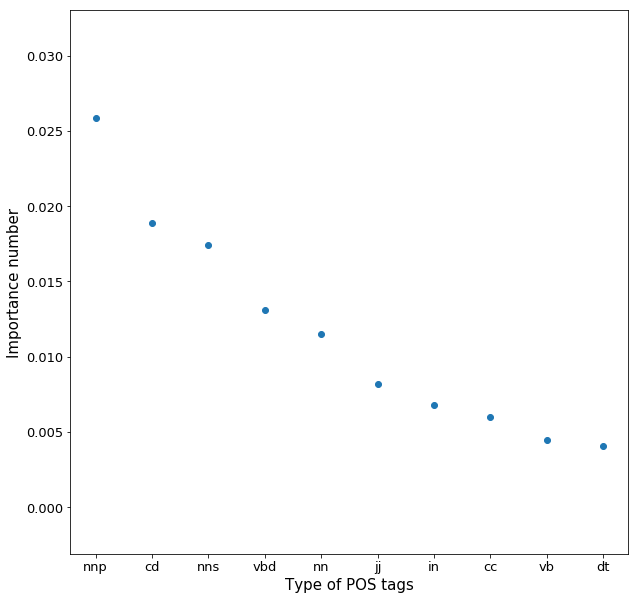

In [80]:
tags,importance_number = zip(*ten_most_important_tags)
plt.figure(figsize=(10,10))
plt.scatter(tags, importance_number)
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel('Type of POS tags', size=15)
plt.ylabel('Importance number', size=15)